In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from scipy.linalg import fractional_matrix_power

import sys

from scipy.stats import norm

# Get the absolute path of the current notebook
sys.path.append('../old_model_generator')
sys.path.append('../ebm')

#from ..model_generator.model_factory import ModelFactory
from old_model_generator.canonical_generator import CanonicalGenerator
from old_model_generator.sample_generator import SampleGenerator

from ebm.probability import log_distributions, fit_distributions
from ebm.mcmc import greedy_ascent, mcmc
from ebm.likelihood import EventProbabilities
### IMPORT EBM AND MODEL GENERATORS

In [8]:
def run_ebm(X,y):
    log_p_e, log_p_not_e = log_distributions(X, y, point_proba=False)
    
    starting_order = np.arange(X.shape[1])
    # just to make optimization procedure do the job, since data where generated with canonical order 0..10
    starting_order = np.random.shuffle(starting_order)
    
    print(f"Starting Order: {starting_order}")
     
    order, loglike, update_iters = greedy_ascent(log_p_e, log_p_not_e, 
                                                n_iter=10_000, order = starting_order,
                                                random_state=2020)
    
    greedy_loglike = loglike
    greedy_order = order
    print(f"Greedy Ascent: {greedy_order}")
    
    orders, loglike, update_iters, probas = mcmc(log_p_e, log_p_not_e,
                                                 order=order, n_iter=500_000,
                                                 random_state=2020)
    
    if len(orders) != 0:
        best_order_idx = np.argmax(loglike)
        best_order = orders[best_order_idx]
    else:
        print("Warning: MCMC did not accept new orders, returning greedy ascent result.")
        best_order = order
        
    print(f"Best order: {best_order}")
    
    return best_order, greedy_order, starting_order

### `sigmoid`

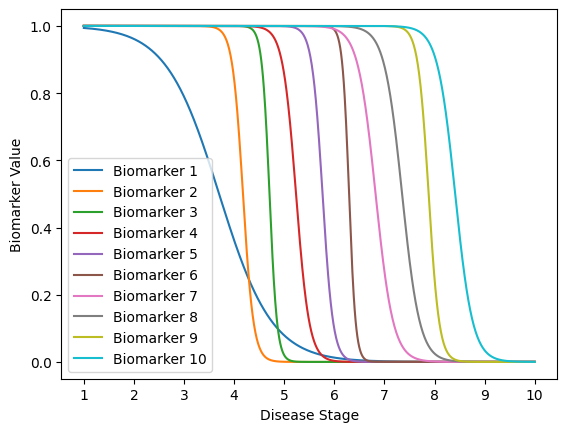

In [6]:
model_type = 'sigmoid'
params = {
    0: {'s': 0.1, 'c': 1.0},
    1: {'s': 0.5, 'c': 10.0},
    2: {'s': 0.7, 'c': 20.0},
    3: {'s': 0.4, 'c': 30.0},
    4: {'s': 0.5, 'c': 40.0},
    5: {'s': 0.8, 'c': 50.0},
    6: {'s': 0.3, 'c': 60.0},
    7: {'s': 0.3, 'c': 70.0},
    8: {'s': 0.5, 'c': 80.0},
    9: {'s': 0.3, 'c': 90.0}
    }

model = CanonicalGenerator(n_biomarker_stages=10,
                           model_type=model_type,
                           biomarkers_params=params,
                           random_state=10)

model.plot_disease_progression()
stage_values = model.get_stage_values()

sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=1000,
                         distribution=norm,
                         dist_params = {'loc':3, 'scale':4, 'random_state':10},
                         add_noise=True,
                         noise_std=0.1,
                         random_state=2)

In [7]:
X = sample.get_X()
y = sample.get_y()

run_ebm(X=X, y=y)

Starting Order: None


100%|██████████| 10000/10000 [00:02<00:00, 3535.05it/s]


Greedy Ascent: [0 1 2 3 4 5 6 7 8 9]


100%|██████████| 500000/500000 [02:29<00:00, 3346.49it/s]


ValueError: attempt to get argmax of an empty sequence